In [7]:
import xlearn as xl
import pandas as pd, numpy as np
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [8]:
# Load data
d = pd.read_csv("turnout_train.csv")
ta = pd.read_csv("turnout_to_assign.csv")

In [9]:
d.columns

Index(['id', 'state', 'treat', 'voted_2006', 'voted_2008', 'voted_2009',
       'voted_2010', 'voted_2011', 'voted_2012', 'voted_2013', 'voted_2014',
       'i_age', 'age_miss', 'voting_history_label', 'black', 'hispanic',
       'other_race', 'white', 'female', 'notfem', 'married'],
      dtype='object')

In [10]:
# no treat, voted_2014. 
# We want to know whether to treat them or not by predicting the differences in Pr(voted_2014) between the treated and untreated.
ta.columns

Index(['id', 'state', 'voted_2006', 'voted_2008', 'voted_2009', 'voted_2010',
       'voted_2011', 'voted_2012', 'voted_2013', 'i_age', 'age_miss',
       'voting_history_label', 'black', 'hispanic', 'other_race', 'white',
       'female', 'notfem', 'married'],
      dtype='object')

In [11]:
# Combine data and create train/test split
comb = pd.concat([d, ta], ignore_index=True)

# Keep selected variables
# comb = comb[['id', 'treat', 'voted_2006', 'voted_2008', 'voted_2010', 'voted_2012', 'voted_2014', 'voting_history_label', 'female', 'married']]

# comb = comb[['id', 'state', 'treat', 'voted_2006', 'voted_2008', 'voted_2010', 'voted_2012', 'voted_2014', 'voting_history_label', 'female', 'married']]

# Only keep AZ and WI, else set everything in 'state' to 'other'
# comb['state'] = comb['state'].apply(lambda x: x if x in ['AZ', 'WI'] else 'other')

comb['to_assign'] = comb['voted_2014'].isna() # people for which we want to assign treatment
train_idx = comb[~comb['to_assign']].sample(frac=1, random_state=72540).index # train set
comb['train'] = comb.index.isin(train_idx)
comb

,id,state,treat,voted_2006,voted_2008,voted_2009,voted_2010,voted_2011,voted_2012,voted_2013,...,voting_history_label,black,hispanic,other_race,white,female,notfem,married,to_assign,train
0,2426706,AZ,0.0,0,1,0,0,0,1,0,...,above,0,0,0,1,1,0,0,False,True
1,2426707,FL,1.0,0,1,0,1,0,1,0,...,above,1,0,0,0,0,1,0,False,True
2,2426709,FL,1.0,0,1,0,0,0,1,0,...,average,0,0,0,1,1,0,0,False,True
3,2426710,LA,1.0,0,0,0,1,0,1,0,...,average,1,0,0,0,1,0,0,False,True
4,2426711,WI,1.0,0,1,0,1,0,1,0,...,above,0,0,0,1,1,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826357,4414214,WI,NaN,1,1,0,1,0,1,0,...,above,0,0,0,1,1,0,0,True,False
2826358,4414215,AR,NaN,0,1,0,1,0,1,0,...,above,1,0,0,0,0,1,0,True,False
2826359,4414216,KY,NaN,0,1,0,1,1,1,0,...,above,1,0,0,0,1,0,1,True,False
2826360,4414217,FL,NaN,1,0,0,0,0,1,0,...,average,0,0,0,1,1,0,0,True,False


In [12]:
# Fit separate models for treatment and control
if 'voting_history_label' in comb.columns:
    comb = pd.get_dummies(comb, columns=['voting_history_label'], drop_first=True)
if 'state' in comb.columns:
    comb = pd.get_dummies(comb, columns=['state'], drop_first=True)

# Change True to 1 and False to 0 for all columns
for col in comb.columns:
    if comb[col].dtype == 'bool':
        comb[col] = comb[col].astype(int)


comb_train = comb[(comb['train'] == 1) & (comb['to_assign'] == 0)]
comb_test = comb[(comb['train'] == 0) & (comb['to_assign'] == 0)]
comb_to_predict = comb[comb['to_assign'] == 1]

X_train_id = comb_train['id']
X_test_id = comb_test['id']
X_to_predict_id = comb_to_predict['id']

X_train = comb_train.drop(['id', 'voted_2014', 'to_assign', 'train'], axis=1)
X_test = comb_test.drop(['id', 'voted_2014', 'to_assign', 'train'], axis=1)
X_to_predict = comb_to_predict.drop(['id', 'voted_2014', 'to_assign', 'train'], axis=1)

X_train_treat = X_train[X_train['treat'] == 1]
X_train_control = X_train[X_train['treat'] == 0]
X_test_treat = X_test[X_test['treat'] == 1]
X_test_control = X_test[X_test['treat'] == 0]

y_train_treat = comb_train[comb_train['treat'] == 1]['voted_2014']
y_train_control = comb_train[comb_train['treat'] == 0]['voted_2014']
y_test_treat = comb_test[comb_test['treat'] == 1]['voted_2014']
y_test_control = comb_test[comb_test['treat'] == 0]['voted_2014']

X_train_treat = X_train_treat.drop('treat', axis=1)
X_train_control = X_train_control.drop('treat', axis=1)
X_train = X_test.drop('treat', axis=1)
X_test = X_test.drop('treat', axis=1)
X_test_treat = X_test_treat.drop('treat', axis=1)
X_test_control = X_test_control.drop('treat', axis=1)
X_to_predict = X_to_predict.drop('treat', axis=1)

In [13]:
X_train_treat

,voted_2006,voted_2008,voted_2009,voted_2010,voted_2011,voted_2012,voted_2013,i_age,age_miss,black,...,state_KS,state_KY,state_LA,state_ME,state_MI,state_NC,state_NH,state_SD,state_TX,state_WI
1,0,1,0,1,0,1,0,40.000000,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,32.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,53.000000,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,0,1,0,41.813999,1,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,28.000000,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412138,1,0,0,0,0,0,0,73.000000,0,0,...,0,0,0,0,0,1,0,0,0,0
1412140,0,0,0,0,0,1,0,61.000000,0,0,...,0,1,0,0,0,0,0,0,0,0
1412141,0,0,0,0,1,0,0,29.000000,0,0,...,0,1,0,0,0,0,0,0,0,0
1412142,0,1,0,1,0,0,0,33.000000,0,0,...,0,1,0,0,0,0,0,0,0,0


## View correlations

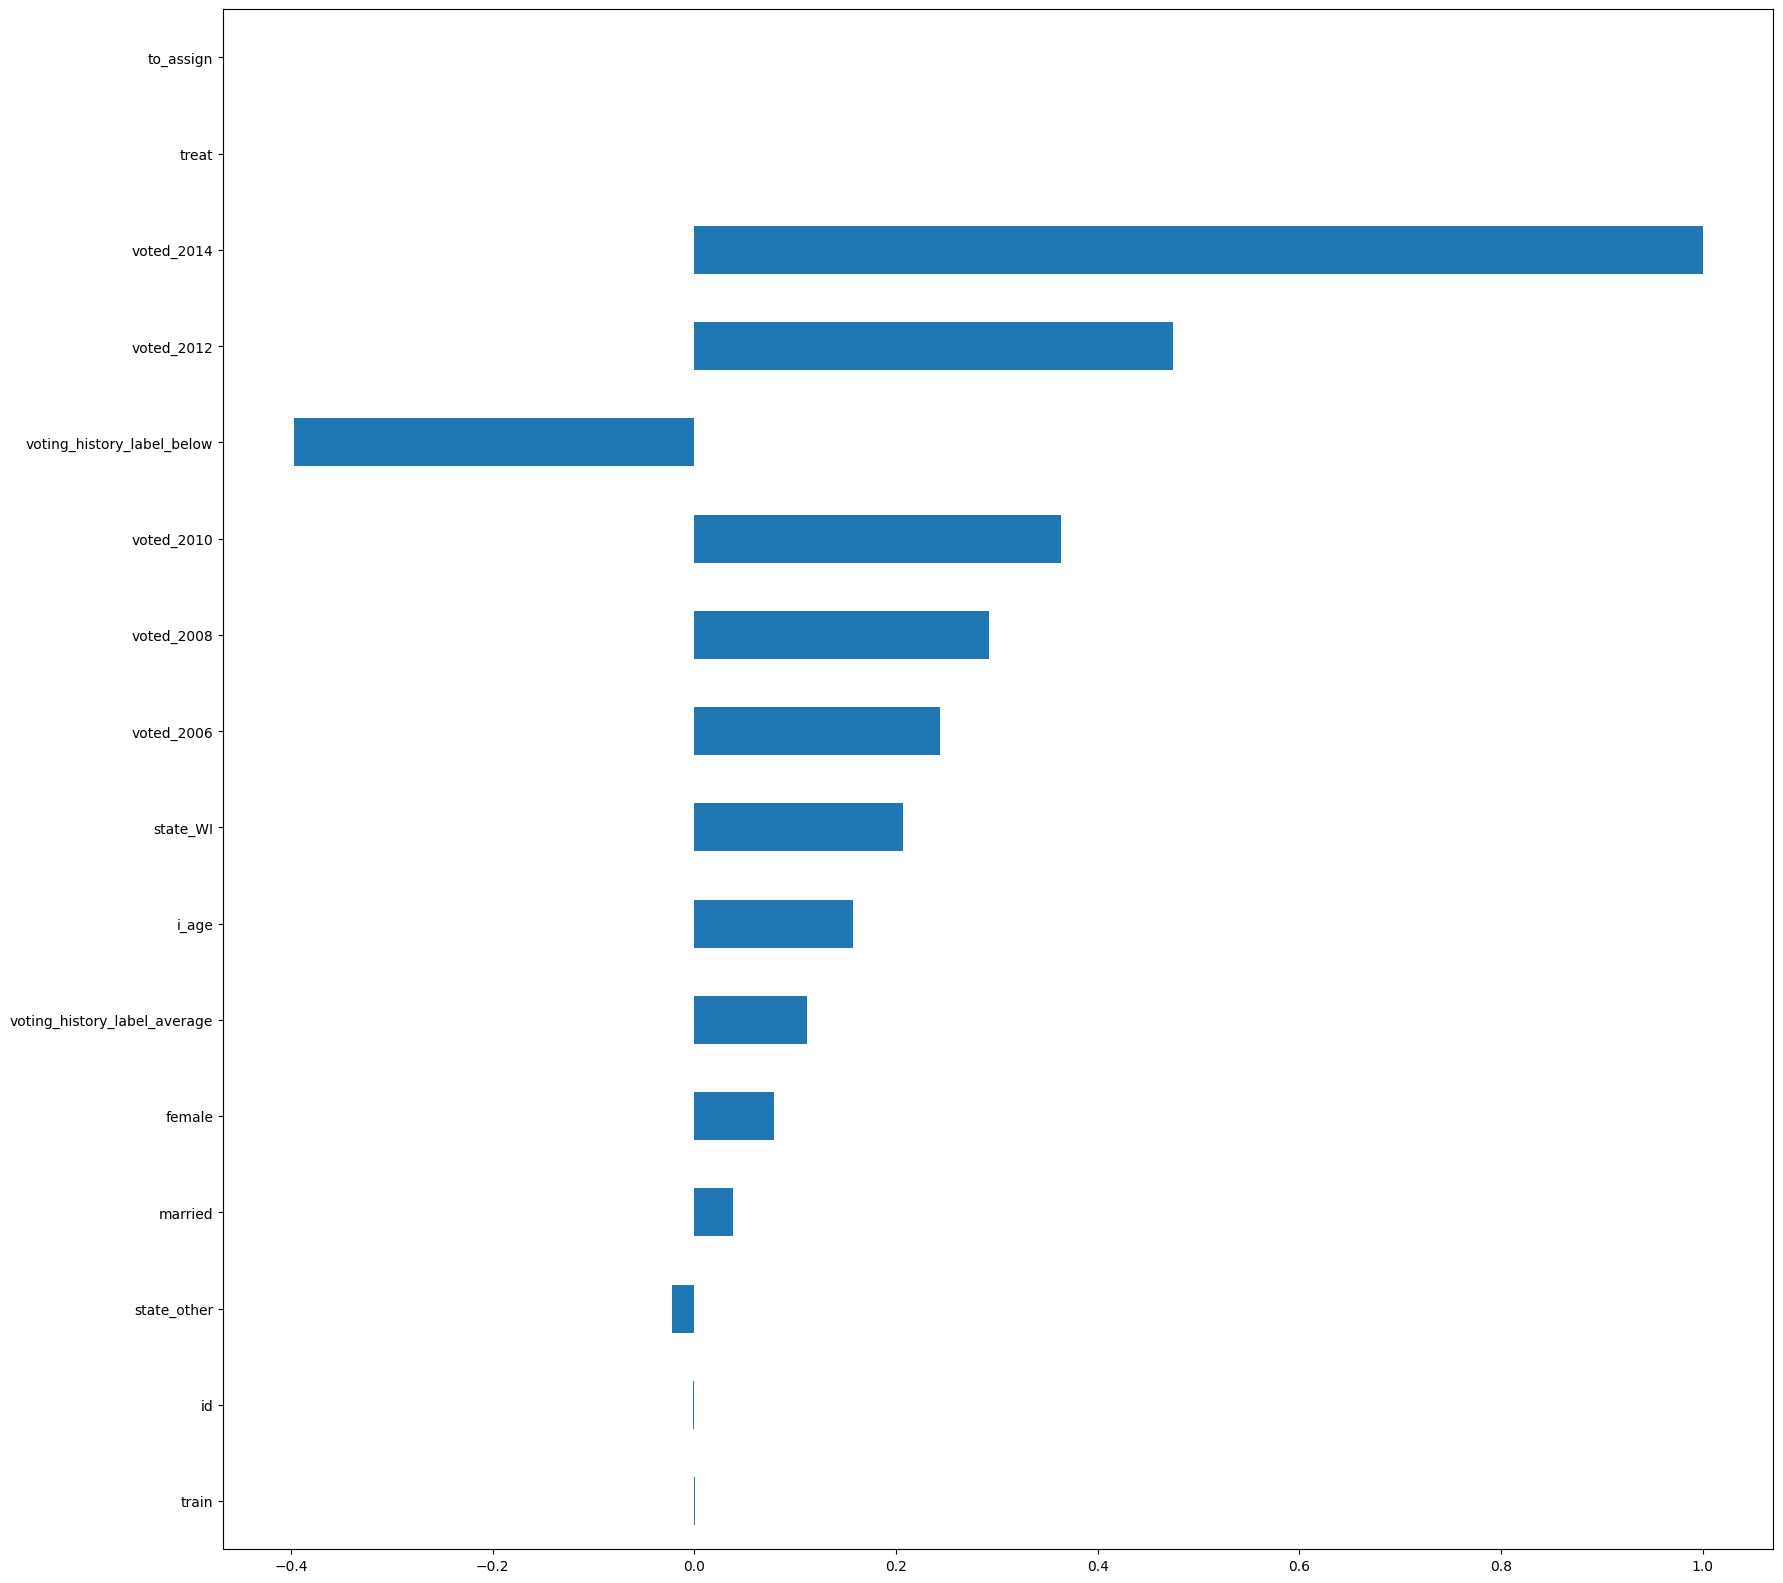

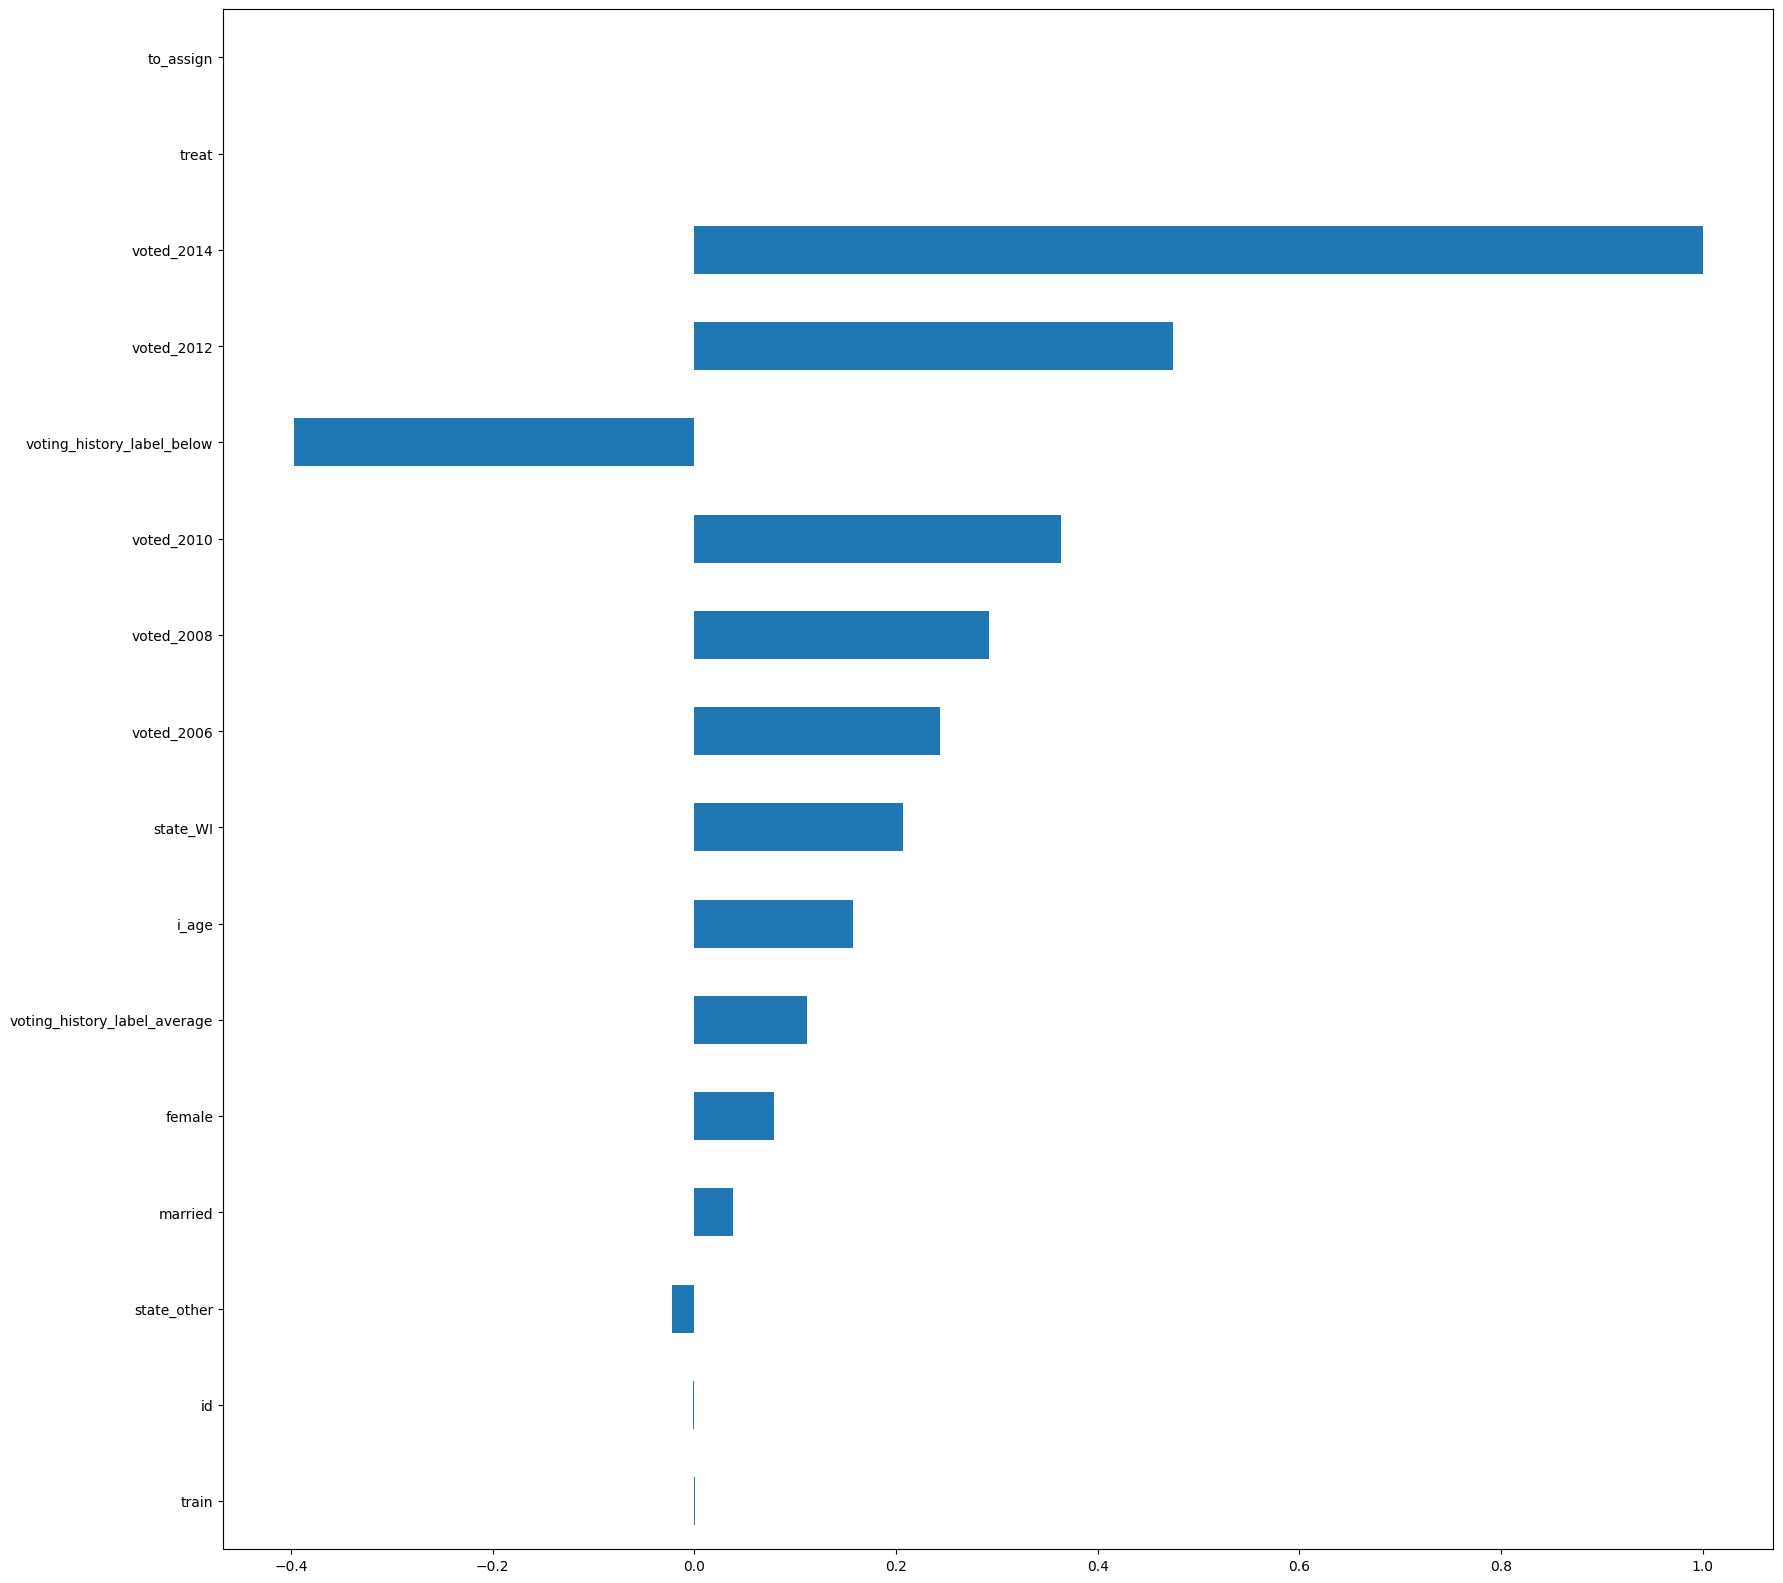

In [8]:
# Plot correlation for 'voted_2014' columns with all other columns
# Get correlation and plot as bar graph 
corr_treat = comb[comb['treat'] == 1].corr()
corr_treat = corr_treat['voted_2014']
corr_control = comb[comb['treat'] == 0].corr()
corr_control = corr_control['voted_2014']

# Sort by magnitude
corr_treat = corr_treat.reindex(corr_treat.abs().sort_values(ascending=True).index)
corr_control = corr_treat.reindex(corr_treat.abs().sort_values(ascending=True).index)

plt.figure(figsize=(20, 20))
corr_treat.plot(kind='barh')
plt.show()

plt.figure(figsize=(20, 20))
corr_control.plot(kind='barh')
plt.show()

In [9]:
# Combine y_train_treat with X_train_treat in a new dataframe. The column 'voted_2014' is the first column.
# Do the same for y_train_control and X_train_control.
train_treat = pd.concat([y_train_treat, X_train_treat], axis=1)
train_control = pd.concat([y_train_control, X_train_control], axis=1)
test_treat = pd.concat([y_test_treat, X_test_treat], axis=1)
test_control = pd.concat([y_test_control, X_test_control], axis=1)

# Save as csv
train_treat.to_csv('train_treat.csv', index=False)
train_control.to_csv('train_control.csv', index=False)

# Convert to libffm format
def csv_to_libffm(df, outputfilepath, label_col='voted_2014'):
    """
    Convert a pandas DataFrame into the LibFFM format and return as a DataFrame.
    
    Parameters:
    - df: pandas DataFrame, the input data.
    - label_col: str, the name of the column that contains the label.
    
    Returns:
    - pandas DataFrame with LibFFM formatted data.
    """
    # Copy the DataFrame to avoid modifying the original data
    ffm_df = df.copy()
    
    # Initialize a list to store the converted rows as strings
    ffm_rows = []
    
    # Generate a field map
    fields = {col: i for i, col in enumerate(ffm_df.columns) if col != label_col}
    
    # Iterate over rows to convert each to LibFFM format
    for _, row in ffm_df.iterrows():
        # Start with the label
        ffm_row = [str(row[label_col])]
        
        # Iterate over each feature
        for col, value in row.items():
            if col == label_col:
                continue  # Skip the label column
            
            # Append the feature in field:index:value format
            field_idx = fields[col]
            ffm_row.append(f"{field_idx}:{field_idx}:{value}")
        
        # Join the features and add to the list
        ffm_rows.append(' '.join(ffm_row))
    
    # Create a DataFrame from the ffm_rows list
    ffm_df = pd.DataFrame(ffm_rows, columns=['LibFFM_Format'])
    ffm_df.to_csv(outputfilepath, index=False, header=False)



In [10]:
# Write the LibFFM files
csv_to_libffm(train_treat, 'train_treat.csv')
csv_to_libffm(train_control, 'train_control.csv')
csv_to_libffm(test_treat, 'test_treat.csv')
csv_to_libffm(test_control, 'test_control.csv')

In [11]:
to_predict = X_to_predict.copy()
to_predict['voted_2014'] = 0 # just to comply with data format requirements
csv_to_libffm(to_predict, 'X_to_predict.csv')

X_to_predict_id.to_csv('X_to_predict_id.csv', index=False)

## XGB - feature importances

In [14]:
# Run XGBoost model with xgboost
# Create DMatrix for training
dtrain_treat = xgb.DMatrix(X_train_treat, label=y_train_treat)
dtrain_control = xgb.DMatrix(X_train_control, label=y_train_control)
dtest = xgb.DMatrix(X_to_predict)

# Set parameters
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

# Train the model
num_round = 10
bst_treat = xgb.train(param, dtrain_treat, num_round)
bst_control = xgb.train(param, dtrain_control, num_round)

# Predict and get who is treated
pred_treat = bst_treat.predict(dtest)
pred_control = bst_control.predict(dtest)
est_effect = pred_treat - pred_control
treat = (est_effect > 0.0053) * 1

df_to_submit = X_to_predict_id.to_frame()
df_to_submit['treat'] = treat
df_to_submit.to_csv("df_to_submit-xgb.csv.gz", index=False, compression='gzip')
df_to_submit

,id,treat
1412144,3000001,1
1412145,3000002,0
1412146,3000003,1
1412147,3000004,0
1412148,3000005,1
...,...,...
2826357,4414214,0
2826358,4414215,0
2826359,4414216,1
2826360,4414217,1


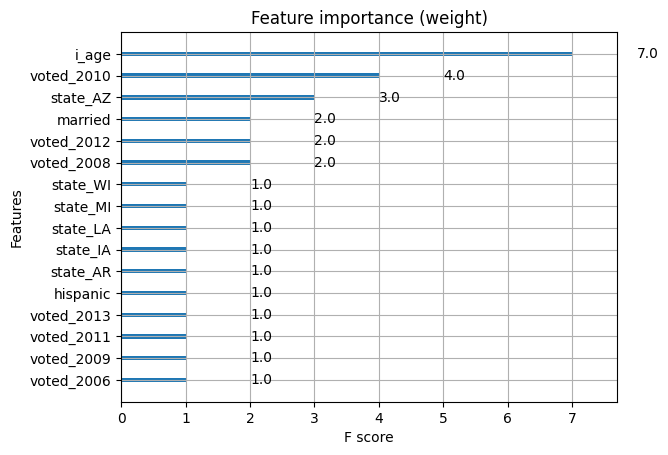

In [15]:
# Get feature importance
xgb.plot_importance(bst_treat, importance_type='weight', title='Feature importance (weight)', max_num_features=30)
plt.show()

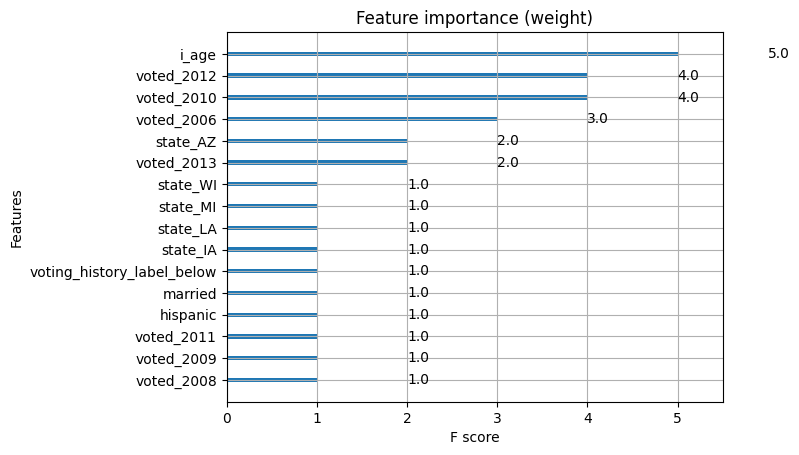

In [16]:
xgb.plot_importance(bst_control, importance_type='weight', title='Feature importance (weight)', max_num_features=30)
plt.show()

## Logistic Regression

In [40]:
# Logistic Regression
scaler_treat = preprocessing.StandardScaler().fit(X_train_treat)
scaler_control = preprocessing.StandardScaler().fit(X_train_control)

model_treat = LogisticRegression().fit(scaler_treat.transform(X_train_treat), y_train_treat)
model_control = LogisticRegression().fit(scaler_control.transform(X_train_control), y_train_control)

<Axes: >

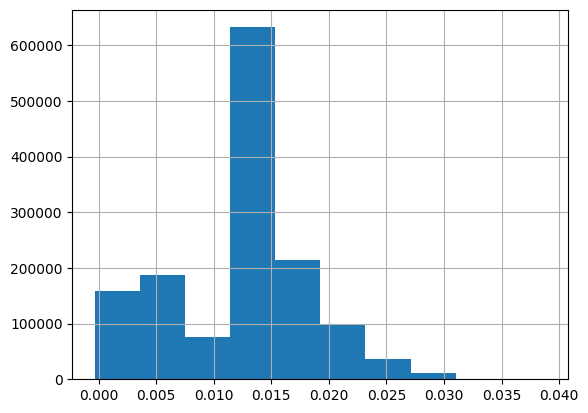

In [41]:
# Get predictions
predictions = X_to_predict.copy()
predictions['y_1_hat'] = model_treat.predict_proba(scaler_treat.transform(X_to_predict))[:, 1]
predictions['y_0_hat'] = model_control.predict_proba(scaler_control.transform(X_to_predict))[:, 1]
predictions['est_effect'] = predictions['y_1_hat'] - predictions['y_0_hat']
predictions['treat'] = (predictions['est_effect'] > 0.0053) * 1
predictions['est_effect'].hist()

In [42]:
df_to_submit = X_to_predict_id.to_frame()
df_to_submit['treat'] = predictions['treat']
df_to_submit.to_csv("df_to_submit.csv.gz", index=False, compression='gzip')
df_to_submit

,id,treat
1412144,3000001,1
1412145,3000002,1
1412146,3000003,1
1412147,3000004,0
1412148,3000005,1
...,...,...
2826357,4414214,0
2826358,4414215,1
2826359,4414216,0
2826360,4414217,1
